In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output  # this has to be removed if used on a single script
import random
from preprocess import preprocess_seismo, preprocess_coord
import scipy.io
import GPy
import time

In [2]:
X_dim = 501 # size of the seismograms
y_dim = 4 # dimension of labels
# load data
split = 2000
test_valid = 1000
X_data_ = np.loadtxt('./seismograms_4000seismo_ISO.txt')[:, :X_dim]
y_data_ = np.loadtxt('./coordinates_4000seismo_ISO.txt')

In [3]:
# # pre-process data
X_data_preprocessed = preprocess_seismo(X_data_, split, log=False, std=False, rescale=False, rescale_onlyamp=False)
X_data = X_data_preprocessed[:split]
X_data_test = X_data_preprocessed[split+test_valid:]

No preprocessing step done.


In [4]:
y_data_preprocessed, meancoords, stdcoords = preprocess_coord(y_data_, split=split, test_valid=test_valid, sort=False, std=True)
y_data = y_data_preprocessed[:split]
y_data_valid =  y_data_preprocessed[split:split+test_valid]
y_data_test =  y_data_preprocessed[split+test_valid:]

Shifted and standardized; not sorted
Mean: [-1.49500000e-01  6.00000000e-02 -1.23196500e+02  1.29906166e+02], std dev: [23.03473789 23.21808347 68.8275736  64.09918073]


In [5]:
selected_comp = 100

In [8]:
# sort elements
absolute_train = np.abs(X_data)
absolute_test = np.abs(X_data_test)
dominantseismo_train = np.zeros((split, selected_comp))
dominantseismo_test = np.zeros((test_valid, selected_comp))
indices_train = np.zeros((split, selected_comp), int)
indices_val = np.zeros((test_valid, selected_comp), int)
indices_test = np.zeros((test_valid, selected_comp), int)
for i in range(split):
    indices_train[i] = absolute_train[i].argsort()[::-1][:selected_comp]
    indices_train[i].sort()
    dominantseismo_train[i] = X_data[i, indices_train[i]]
for i in range(test_valid):
    indices_test[i] = absolute_test[i].argsort()[::-1][:selected_comp]
    indices_test[i].sort()
    dominantseismo_test[i] = X_data_test[i, indices_test[i]]


# standardize Idx
indices_train_mean = np.mean(indices_train, axis=0)
indices_train_std = np.std(indices_train, axis=0)
indices_train_stand = (indices_train - indices_train_mean)/indices_train_std
indices_test_stand = (indices_test - indices_train_mean)/indices_train_std


# standardize Si
dominantseismo_train_mean = np.mean(dominantseismo_train, axis=0)
dominantseismo_train_std = np.std(dominantseismo_train, axis=0)
dominantseismo_train_stand = (dominantseismo_train - dominantseismo_train_mean)/dominantseismo_train_std
dominantseismo_test_stand = (dominantseismo_test - dominantseismo_train_mean)/dominantseismo_train_std

In [ ]:
def calculate_R2(original, prediction, label, store):
    AM = original.mean()
    BM = prediction.mean()
    c_vect = (original-AM)*(prediction-BM)
    d_vect = (original-AM)**2
    e_vect = (prediction-BM)**2
    r_out = np.sum(c_vect)/float(np.sqrt(np.sum(d_vect)*np.sum(e_vect)))
    print(label+str(r_out))
    store.append(r_out)

In [ ]:
# pred_idx_test_stand = np.load('./Saptarshi/pred_idx_test_stand.npy')
# pred_si_test_stand = np.load('./Saptarshi/pred_si_test_stand.npy')
# pred_idx_test = np.rint(pred_idx_test_stand*indices_train_std+indices_train_mean)
# pred_idx_test[pred_idx_test>(X_dim-1)] = X_dim -1
# pred_idx_test = pred_idx_test.astype(int)
# pred_si_test = pred_si_test_stand*dominantseismo_train_std+dominantseismo_train_mean

In [ ]:
gp_models_Ai = []#np.zeros(number_receivers*selected_comp)
gp_models_ti = []#np.zeros(number_receivers*selected_comp)

for i in range(selected_comp):
    print("idx ", i)
    ker = GPy.kern.Matern32(4,ARD=True) 
    m_load = GPy.models.GPRegression(y_data, dominantseismo_train_stand[:, i].reshape(split, 1), ker, initialize=False)
    m_load.update_model(False) # do not call the underlying expensive algebra on load
    m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
    #m_load[:] = np.load('./saved_models_iso_Saptarshi/model_si_save_{}.npy'.format(i)) # Load the parameters
    m_load[:] = np.load('/home/alessio/Documenti/Projects/seismo2/ISO/Saptarshi/model_si_save_{}.npy'.format(i))
    m_load.update_model(True) # Call the algebra only once
    gp_models_Ai.append(m_load)#[k] = m_load

    kern = GPy.kern.Matern32(4,ARD=True) 
    n_load = GPy.models.GPRegression(y_data, indices_train_stand[:, i].reshape(split, 1), kern, initialize=False)
    n_load.update_model(False) # do not call the underlying expensive algebra on load
    n_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
    #n_load[:] = np.load('./saved_models_iso_Saptarshi/model_idx_save_{}.npy'.format(i)) # Load the parameters
    m_load[:] = np.load('/home/alessio/Documenti/Projects/seismo2/ISO/Saptarshi/model_idx_save_{}.npy'.format(i))
    n_load.update_model(True) # Call the algebra only once
    gp_models_ti.append(n_load)#[k] = n_load

In [ ]:
def model_GP(As):
    Ai_pred = np.zeros(selected_comp)
    for i in range(selected_comp):
        Ai_pred_tmp = gp_models_Ai[i].predict(As.reshape(1,y_dim))[0]
        Ai_pred[i] = Ai_pred_tmp[:, 0]
    ti_pred = np.zeros(selected_comp, dtype=int)
    for i in range(selected_comp):
        ti_pred_tmp = gp_models_ti[i].predict(As.reshape(1,y_dim))[0]
        ti_pred[i] = ti_pred_tmp[:, 0]
    return Ai_pred, ti_pred

In [9]:
def backrescale_given_Ai_pred_ti_pred(Ai_pred, ti_pred):
    pred_idx = np.zeros((test_valid,selected_comp))
    pred_si = np.zeros((test_valid, selected_comp))
    for i in range(test_valid):
        pred_idx[i] = np.rint(ti_pred[i]*indices_train_std+indices_train_mean)
    pred_idx[pred_idx>(X_dim-1)] = X_dim -1
    pred_idx = pred_idx.astype(int)
    for i in range(test_valid):
        pred_si[i] = Ai_pred[i]*dominantseismo_train_std+dominantseismo_train_mean
    prediction = np.zeros((test_valid, X_dim))
    for i in range(test_valid):
        for j in range(selected_comp):
            prediction[i, pred_idx[i, j]] = pred_si[i, j]
    return prediction

In [ ]:
# start_time_inference = time.time()

for i in range(10):
    new_coords = y_data[i]

    #shifted = coordinate - np.array([41,41,244])
    #distances = np.linalg.norm(shifted)
    #new_coords = np.zeros(4)
    #new_coords[:3] = shifted
    #new_coords[-1] = distances
    #new_coords = (new_coords - meancoords)/stdcoords
    #new_coords = new_coords.reshape((1,y_dim))

    Ai_pred, ti_pred = model_GP(new_coords)
    ymodel = backrescale_given_Ai_pred_ti_pred(Ai_pred, ti_pred)
    
    plt.plot(X_data[i], label='original', color='blue')
    plt.plot(ymodel, label='reconstructed', color='red')
    plt.show()
    plt.close()
# timeinf = time.time() - start_time_inference
# print("timeinf", timeinf)
# np.save("Saptarshi_inftime.npy", timeinf)

[[   0.            0.            0.         ...   -3.45800305
   -59.09922127 -154.20951402]
 [   0.            0.            0.         ...   15.0911654
    20.45385339   28.0129043 ]
 [   0.            0.            0.         ...  -19.23575264
     0.            0.        ]
 ...
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...  113.17121041
     0.         -206.62254245]]
(1000, 501)
[-0.6012875  -1.16547087 -1.14494084  1.1602427 ]


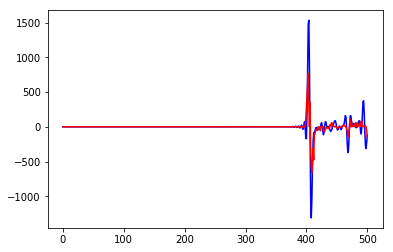

[ 0.78791867  0.68653384 -1.420993    1.44155007]


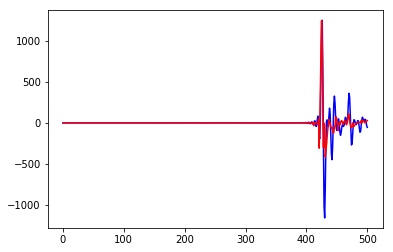

[ 1.43910906 -0.86398173 -0.52019123  0.52589185]


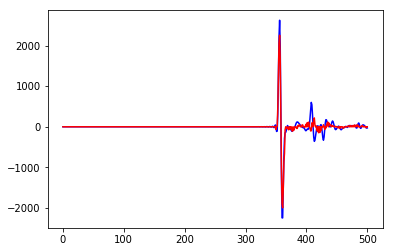

[-0.73152558 -1.25161063 -0.30225532  0.28027503]


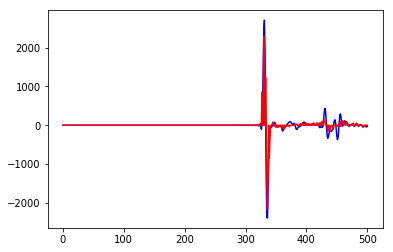

[ 0.78791867  0.64346396  1.17970888 -1.27634248]


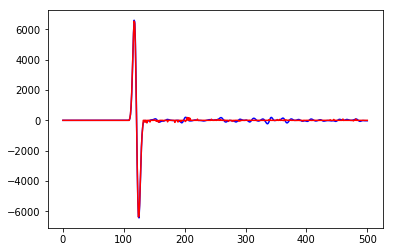

[ 1.2220456  -1.2946805   0.59854645 -0.59612336]


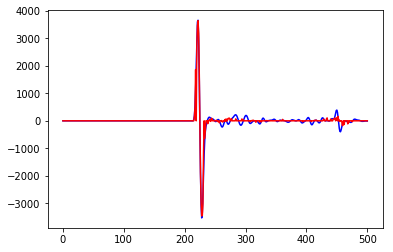

[ 0.48402982 -0.77784198  0.71477894 -0.82619046]


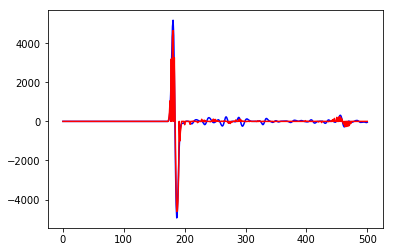

[-0.77493827 -0.64863235 -1.52269642  1.54907782]


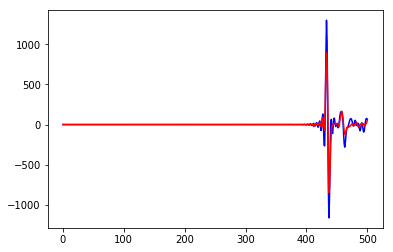

[-0.21057327 -1.72537927  0.58401739 -0.58713429]


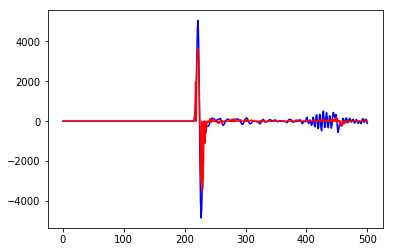

[-0.47104942 -0.04565407 -0.79624338  0.75564462]


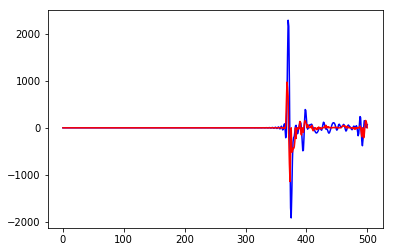

In [10]:
pred_test_std = np.load('./../ISO/Saptarshi/pred_si_test_stand.npy')
idx_test_std = np.load('./../ISO/Saptarshi/pred_idx_test_stand.npy')
# print(pred_test_std)
# print(idx_test_std)
seismorec = backrescale_given_Ai_pred_ti_pred(pred_test_std, idx_test_std)
print(seismorec)
print(np.shape(seismorec))
for i in range(10):
    print(y_data_test[i])
    plt.plot(X_data_test[i], label='original', color='blue')
    plt.plot(seismorec[i], label='reconstructed', color='red')
    plt.show()
    plt.close()
np.save('X_data_test.npy', X_data_test)
np.save('seismorec_test_D18.npy', seismorec)